In [2]:
import sisl
from ase.build import molecule
from ase.visualize import view
from tqdm.notebook import tqdm
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.optimize as sciopt
from Block_matrices.Block_matrices import block_td, block_sparse, Interpolate, Blocksparse2Numpy
from nanobtl.utils import *
from nanobtl.cap import *
from nanobtl.trans import *
from nanobtl.ac import *
from time import time

# Bound state in graphene

In [3]:
R = [0.1, 1.5]
hop = [0., -2.75] #on-site and hopping element in eV
bond = 1.42       #distance between 2 atoms in Angstrom

axis = 0
bc_axis = 1
k = 0.35
eta = 1e-3
tol = 1e-3
nh = 100
hlist = np.linspace(-2.7,-0.05,nh)
dlist = bond*(hop[1]/hlist)**0.5
guess_list = np.linspace(0.25,0.01,nh)

In [4]:
#Geometry
gr_er = sisl.geom.graphene(bond=bond, orthogonal = True)
gr_el = gr_er.mirror('yz').translate([-4.2/3,0,0]) #mirror to generate a symmetric geometry necessary for optimization
gr_dev_only = sisl.geom.graphene(bond=bond, orthogonal = True).tile(2,0)
gr_dev = gr_el.add(gr_dev_only).add(gr_er.translate(gr_dev_only.cell[axis]))

#Construction of Hamiltonians
H_er = sisl.Hamiltonian(gr_er)
H_er.construct((R,hop))
H_dev = sisl.Hamiltonian(gr_dev)
H_dev.construct((R,hop))
H_el = sisl.Hamiltonian(gr_el)
H_el.construct((R,hop))

#Atomic number of the 2 middle carbon atoms for the defect
nbond = [(4+3,8)]  

0it [00:00, ?it/s]

Text(0, 0.5, 'boundness')

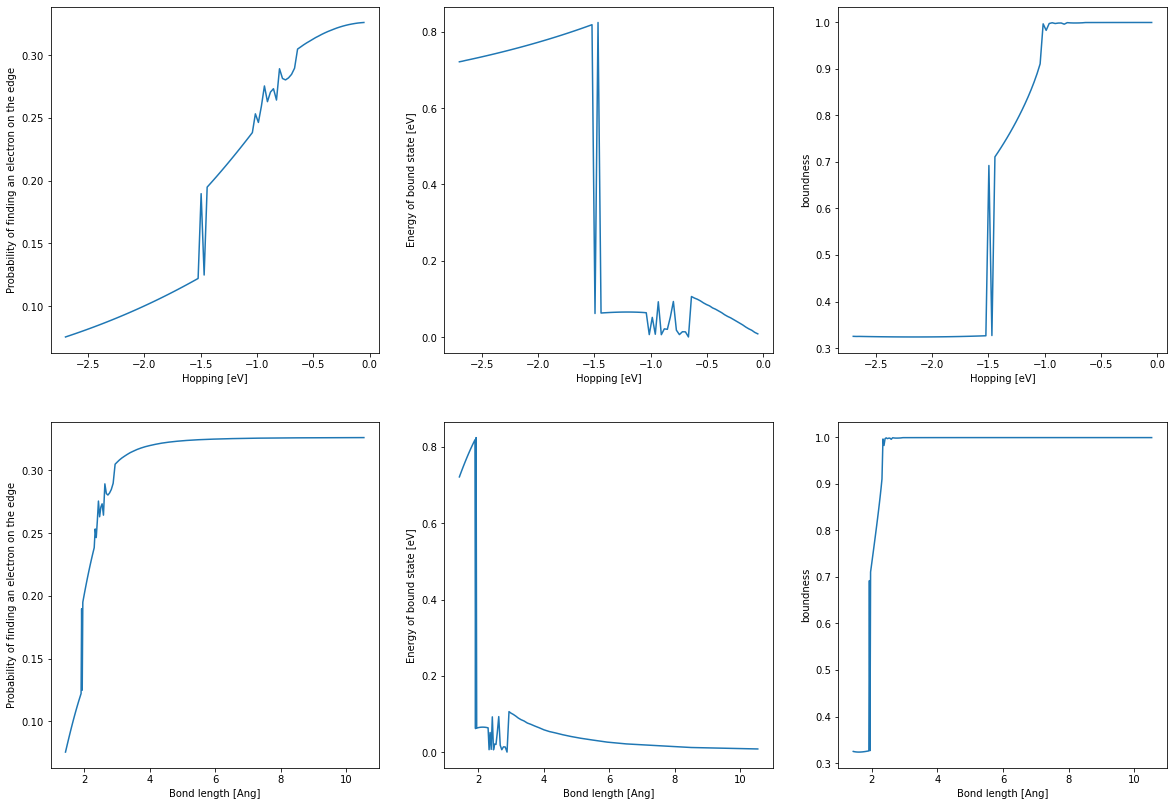

In [5]:
boundness  = []
edge_state = []
e_state    = []

H_left    = matrix_elements(H_el,pdir = 1-axis, tdir = axis,which = 0)
V_left    = matrix_elements(H_el,pdir = 1-axis, tdir = axis,which = -1)
H_right   = matrix_elements(H_er,pdir = 1-axis, tdir = axis,which = 0)
V_right   = matrix_elements(H_er,pdir = 1-axis, tdir = axis,which = 1)

for h, e_guess in tqdm(zip(hlist,guess_list)):
    for i,j in nbond:
        H_dev.H[i,j], H_dev.H[j,i] = h, h
    H_center_plus = matrix_elements(H_dev, pdir = 1-axis, tdir = axis, which=0 )
    bound, E1, state = quasi_particle(e_guess,k,H_left, V_left, H_center_plus, H_right, V_right, eta, tol, 500)
    boundness.append(1-bound)
    edge_state.append(np.abs(state[nbond[0][0]]))
    e_state.append(np.abs(E1))

plt.rcParams["figure.figsize"] = (20,14)
plt.subplot(2,3,1)
plt.plot(hlist,2*np.array(edge_state)**2)
plt.xlabel('Hopping [eV]')
plt.ylabel('Probability of finding an electron on the edge')
plt.subplot(2,3,2)
plt.plot(hlist,e_state)
plt.xlabel('Hopping [eV]')
plt.ylabel('Energy of bound state [eV]')
plt.subplot(2,3,3)
plt.plot(hlist,boundness)
plt.xlabel('Hopping [eV]')
plt.ylabel('boundness')
plt.subplot(2,3,4)
plt.plot(dlist,2*np.array(edge_state)**2)
plt.xlabel('Bond length [Ang]')
plt.ylabel('Probability of finding an electron on the edge')
plt.subplot(2,3,5)
plt.plot(dlist,e_state)
plt.xlabel('Bond length [Ang]')
plt.ylabel('Energy of bound state [eV]')
plt.subplot(2,3,6)
plt.plot(dlist,boundness)
plt.xlabel('Bond length [Ang]')
plt.ylabel('boundness')

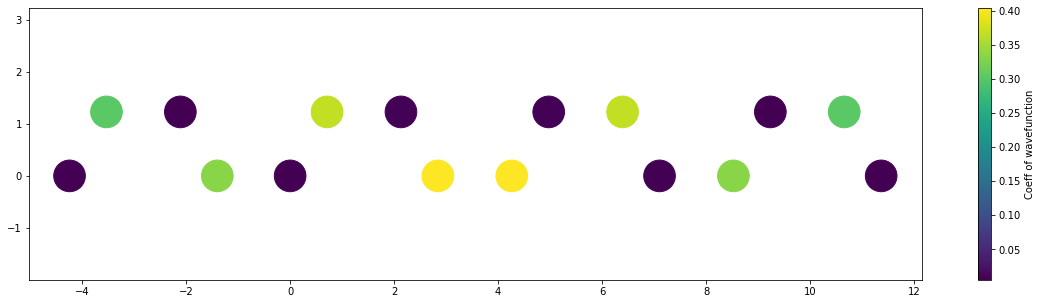

In [6]:
plt.rcParams["figure.figsize"] = (20,5)
plt.scatter(gr_dev[:,0],gr_dev[:,1],c=np.abs(state),s=1000) ; plt.axis("equal") ; plt.colorbar(label="Coeff of wavefunction")

# AC

## Nanotube

In [7]:
R = [0.1, 1.5]
hop = [0., -2.75] #on-site and hopping element in eV
bond = 1.42
N_tile = 20
n = 3
pos_chain_coef = np.array([1,0])
N_chain = 0
h = -2.75
axis = 0
bc_axis=1

Geometry : Gamma point (k=0) of graphene is equivalent to a nanotube

(-4.189, 87.969, -0.3074390183434757, 6.456219385212989)

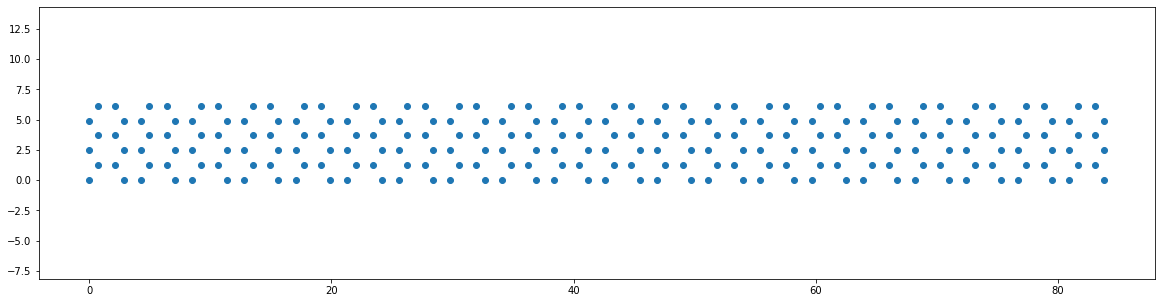

In [8]:
SWNT = sisl.geom.graphene(bond=bond,orthogonal = True).tile(n,1).tile(N_tile,0)

nbond = []
for i in range(n):
    nbond.append((2*n*(N_tile-2)+3+4*i,2*n*N_tile+4*i))

if N_chain > 0:
    chain_pos0 = (SWNT.xyz[nbond[n//2][0]]*pos_chain_coef[0]+SWNT.xyz[nbond[n//2][1]]*pos_chain_coef[1]) + np.array([0,0,3**0.5/2*bond])
    chain_pos = np.vstack([chain_pos0+ni*np.array([0,0,bond]) for ni in range(N_chain)])
    print(chain_pos)
    chain = sisl.Geometry(chain_pos, atoms="C")

    SWNT = SWNT.insert(nbond[-1][1]+1,chain)

H = sisl.Hamiltonian(SWNT)
H.construct((R,hop))
H.set_nsc([1,3,1])

plt.scatter(SWNT.xyz[:,0],SWNT.xyz[:,1]) ; plt.axis("equal")

Self-energy

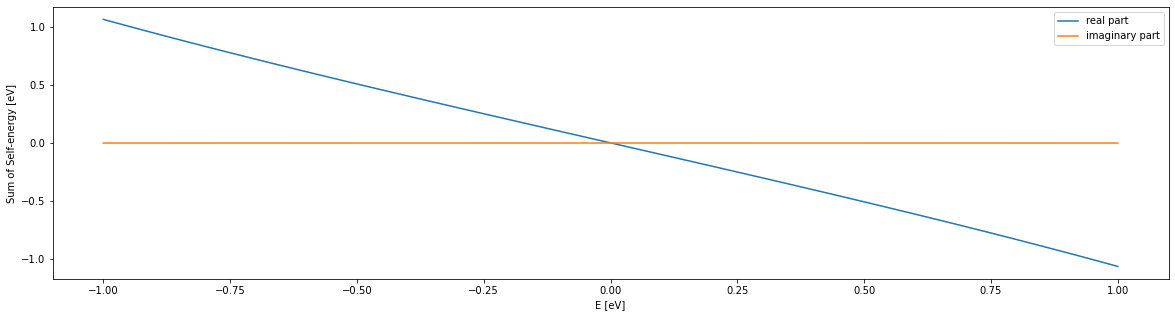

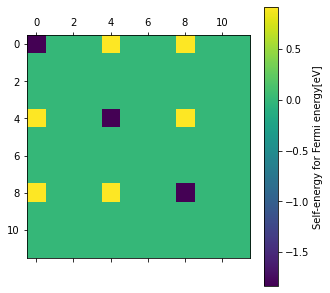

In [9]:
gamma = 1 #strength of coupling between electrodes and device
eta_el = 1e-3

gr_el = sisl.geom.graphene(orthogonal = True).tile(n,1).tile(1,0)
H_el = sisl.Hamiltonian(gr_el)
H_el.construct((R,hop))
H_left_obj    = matrix_elements(H_el,pdir = 1-axis, tdir = axis,which = 0)
V_left_obj    = matrix_elements(H_el,pdir = 1-axis, tdir = axis,which = -1)
V_right_obj    = matrix_elements(H_el,pdir = 1-axis, tdir = axis,which = 1)

hkl = phase_mult(H_left_obj,0)
vkl = phase_mult(V_left_obj,0)
vkr = phase_mult(V_right_obj,0)

E = np.linspace(-1,1,100)
se_l = []
for i,e in enumerate(E):
    se_l.append(SE(e+1j*eta_el,hkl,vkl).sum())

plt.plot(E,np.array(se_l).real,label="real part")
plt.plot(E,np.array(se_l).imag,label="imaginary part")
plt.legend()
plt.xlabel("E [eV]")
plt.ylabel('Sum of Self-energy [eV]')

hkl = phase_mult(H_left_obj,0)
vkl = phase_mult(V_left_obj,0)
vkr = phase_mult(V_right_obj,0)
SE_l0 = gamma*SE(0+1j*eta_el,hkl,vkl)
SE_r0 = gamma*SE(0+1j*eta_el,hkl,vkr)

plt.matshow(SE_l0.imag)
plt.colorbar(label='Self-energy for Fermi energy[eV]')

The self-energy must be approximately constant for the range of energy considered (\~0.1 eV for 200 THz). Here it is verified so we take the self-energy at fermi-energy for all our further calculations. If we consider graphene, the self-energy is not constant at all around fermi energy, therefore we need to extend the electrodes and add a complex absorbing potential on them in order to perform AC computations.

The frequency range is directly proportional to the length of the system. The energy range considered corresponds to the width of the fermi-dirac function at room temperature (\~0.5 eV).

In [10]:
no = 5
Omega = np.linspace(1e3,90e12*50/N_tile,no) #np.array([10**i for i in range(0,15)])
E = np.linspace(-0.25,0.25,100)
K = np.array([0])

hlist = -np.array([0.1,1.13,2.75])

eta = 0
Temp = 298
V = 0.0

0it [00:00, ?it/s]

Text(0, 0.5, 'Y [e²/h]')

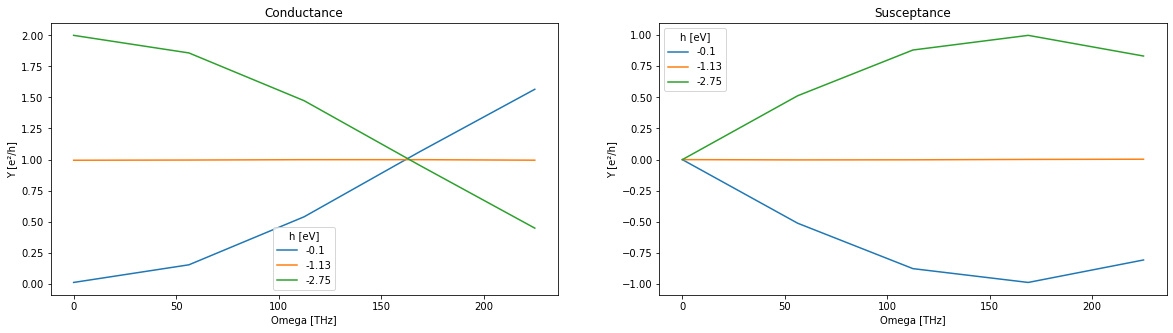

In [11]:
Y = np.zeros((len(hlist),no),dtype=np.complex128)

for ih, h in tqdm(enumerate(hlist)):
    for i,j in nbond:
        H.H[i,j], H.H[j,i] = h, h
    Y[ih] = admittance(E, Omega, K, H, SE_l0, SE_r0, bc_axis, V, block=False, P=[], eta=eta, Temp=Temp, dtype=np.complex128)

plt.subplot(1,2,1)
plt.title("Conductance")
plt.plot(Omega/1e12,Y.T.real,label=hlist)
plt.legend(title='h [eV]')
plt.xlabel("Omega [THz]")
plt.ylabel("Y [e²/h]")
plt.subplot(1,2,2)
plt.title("Susceptance")
plt.plot(Omega/1e12,Y.T.imag,label=hlist)
plt.legend(title='h [eV]')
plt.xlabel("Omega [THz]")
plt.ylabel("Y [e²/h]")